# TensorFlow Basics

TensorFlow describes itself as "an end-to-end open source machine learning platform".

This describes its _purpose_ but not its _function_. In fact, TensorFlow is a tool for performing gradient descent on arbitrarily complicated functions. 

To achieve this:
* TensorFlow users define a computation in terms of a **graph**. 
* Once the graph is defined, TensorFlow can use backpropagation to find the gradients of the computational graph inputs with respect to its outputs, 
* which can in turn be used to optimize the function.

The inputs and outputs of the computational graph are called **tensors**, which are a high-dimensional generalization of numbers. Forward- and back-propagation of tensors **flows** through the graph, hence **TensorFlow**.

Once you get this running you can gradient-descend any differentiable function, thereby optimizing any **convex** function.

## Computation Graph

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Say we have some arbitary function:

$$f(x) = 3x^2 + 4x$$

In standard Python style, we could implement it with a single function:

```
x ---> [3x^2 + 4x] ---> output
```

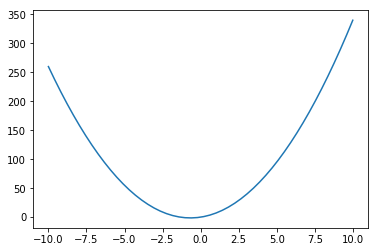

In [2]:
def foo(x):
    return 3*x**2 + 4*x

x = np.linspace(-10,10)
y = foo(x)

plt.plot(x,y)

Two things are notable about this approach.

**1: It's eager**

The result is immediately computed when the function is called.

In [3]:
foo(12)

480

**2: It's all one step**

The computation is difficult to analyze because it has been baked into a single step.

Alternatively, we could break the computation apart into a graph:

```
[3]-------
          \
[2]---[^]--[*]---[+]--->
    /          /
[x]---[*]------   
    /
[4]-
```

In [4]:
import tensorflow as tf

In [5]:
# constants at the left of the graph
const_3 = tf.constant(3.0)
const_2 = tf.constant(2.0)
const_4 = tf.constant(4.0)

In [6]:
# variable at the left
x_var = tf.Variable(1.0, name="x") #0.0 is a placeholder value

In [7]:
# x^2 output
pow_0 = tf.pow(x_var, const_2)

In [8]:
# 4x output
mul_0 = tf.multiply(x_var, const_4)
# 4*(x^2) output
mul_1 = tf.multiply(pow_0, const_4)

In [9]:
# addition
output = tf.add(mul_0, mul_1)
output

<tf.Tensor: id=16, shape=(), dtype=float32, numpy=8.0>

In the above form there's no way to refer to the graph at a later time.

In [10]:
output.graph

AttributeError: Tensor.graph is meaningless when eager execution is enabled.

In [11]:
# variable at the left
x_var = tf.Variable(1.0) #0.0 is a placeholder value

with tf.GradientTape() as t:
    t.watch(x_var)
    
    const_3 = tf.constant(3.0)
    const_2 = tf.constant(2.0)
    const_4 = tf.constant(4.0)
    
    pow_0 = tf.pow(x_var, const_2)
    
    mul_0 = tf.multiply(x_var, const_4)
    mul_1 = tf.multiply(pow_0, const_3)

    output = tf.add(mul_0, mul_1)

In [12]:
x_var

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

In [13]:
output

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=7.0>

In [14]:
# Derivative of z with respect to the original input tensor x
doutput_dx = t.gradient(output, x_var)
doutput_dx

<tf.Tensor: id=66, shape=(), dtype=float32, numpy=10.0>

### Use the gradient for optimization

In [15]:
doutput_dx.numpy()

10.0

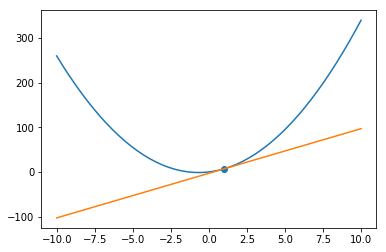

In [16]:
def foo(x):
    return 3*x**2 + 4*x

x = np.linspace(-10,10)
y = foo(x)

plt.plot(x,y)

plt.plot(x,(x-1)*10+foo(1))
plt.scatter([1], [foo(1)])

### Operator overloading

Makes things short.

In [17]:
x_var = tf.Variable(1.0)

with tf.GradientTape() as t:
    t.watch(x_var)
    
    output = 3*x_var**2 + 4*x_var

In [18]:
output

<tf.Tensor: id=84, shape=(), dtype=float32, numpy=7.0>

In [19]:
dy_dx = t.gradient(output, x_var)
dy_dx

<tf.Tensor: id=115, shape=(), dtype=float32, numpy=10.0>

### ` @tf.function ` decorator

Makes things super short.

In [20]:
@tf.function
def foo(x):
    return 3.0*x**2.0 + 4.0*x

In [21]:
x_var = tf.Variable(1.0)

In [22]:
with tf.GradientTape(persistent=True) as t:
    t.watch(x_var)
    
    output = foo(x_var)

In [23]:
dy_dx = t.gradient(output, x_var)
dy_dx

<tf.Tensor: id=190, shape=(), dtype=float32, numpy=10.0>

## Gradient descent

Use the gradient to get an incremental step in the right direction:

In [24]:
learning_rate = 0.03
lesson = -dy_dx*learning_rate
lesson

<tf.Tensor: id=194, shape=(), dtype=float32, numpy=-0.29999998>

Use it to update the guess $x$

In [25]:
x_var + lesson

<tf.Tensor: id=197, shape=(), dtype=float32, numpy=0.70000005>

The tensor `assign` method changes the value of a tensor.

In [26]:
x_var.assign( x_var + lesson )

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.70000005>

In [27]:
x_var

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.70000005>

We can do this over and over again to approach the function minimum.

In [28]:
for i in range(100):
    if i<10 or i%10==0: print( "iteration %d"%i )
    
    with tf.GradientTape() as t:
        t.watch(x_var)

        output = foo(x_var)
    
    dy_dx = t.gradient(output, x_var)
    
    if i<10 or i%10==0:  print( "dy/dx: %f"%dy_dx.numpy() )
    
    x_var.assign( x_var-dy_dx*learning_rate )
    
    if i<10 or i%10==0:  
        print( "x: %f"%x_var.numpy() )
        print()

iteration 0
dy/dx: 8.200001
x: 0.454000

iteration 1
dy/dx: 6.724000
x: 0.252280

iteration 2
dy/dx: 5.513680
x: 0.086870

iteration 3
dy/dx: 4.521218
x: -0.048767

iteration 4
dy/dx: 3.707398
x: -0.159989

iteration 5
dy/dx: 3.040067
x: -0.251191

iteration 6
dy/dx: 2.492855
x: -0.325977

iteration 7
dy/dx: 2.044141
x: -0.387301

iteration 8
dy/dx: 1.676196
x: -0.437587

iteration 9
dy/dx: 1.374480
x: -0.478821

iteration 10
dy/dx: 1.127074
x: -0.512633

iteration 20
dy/dx: 0.154914
x: -0.645495

iteration 30
dy/dx: 0.021293
x: -0.663757

iteration 40
dy/dx: 0.002927
x: -0.666267

iteration 50
dy/dx: 0.000402
x: -0.666612

iteration 60
dy/dx: 0.000055
x: -0.666659

iteration 70
dy/dx: 0.000007
x: -0.666666

iteration 80
dy/dx: 0.000001
x: -0.666667

iteration 90
dy/dx: 0.000001
x: -0.666667



For this simple expression it's straightforward to find the global minimum.

Find slope of the function
$$\frac{d}{dx} 3x^2 + 4x = 6x + 4$$
Set $x$ to zero
$$6x + 4 = 0$$
$$x = -\frac{2}{3}$$

This does in fact seem to be where the optimizer is heading.

## `function` decorator is extremely flexible

In [29]:
def foo_impl(x):
    if tf.abs(x)>1:
        return x**2
    else:
        return tf.abs(x)

# perform decoration manually
foo = tf.function(foo_impl)
    

In [30]:
x = np.linspace(-2,2, num=200)
y = [foo_impl(xi) for xi in x]

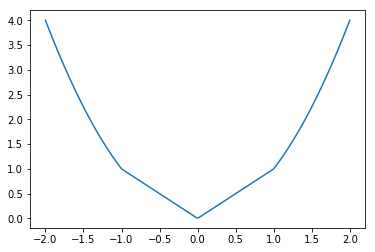

In [31]:
plt.plot(x,y)

The slope $\frac{dy}{dx}$ slightly below 1 is 1.

In [32]:
x_var = tf.Variable(0.99)
with tf.GradientTape() as t:
    t.watch(x_var)
    
    output = foo(x_var)
t.gradient(output, x_var).numpy()

1.0

The slope $\frac{dy}{dx}$ slightly above 1 is 2.

In [33]:
x_var = tf.Variable(1.01)
with tf.GradientTape() as t:
    t.watch(x_var)
    
    output = foo(x_var)
t.gradient(output, x_var).numpy()

2.02

The slope $\frac{dy}{dx}$ at 1 exactly is undefined.

In [34]:
x_var = tf.Variable(1)
with tf.GradientTape() as t:
    t.watch(x_var)
    
    output = foo(x_var)
print( t.gradient(output, x_var) )

None


## gradients of multivariate functions

In [35]:
@tf.function
def multivariate_foo(x, y):
    return x**2 + y**4

x_var = tf.Variable(1.0)
y_var = tf.Variable(1.0)
with tf.GradientTape(persistent=True) as t:
    t.watch(x_var)
    t.watch(y_var)
    
    z_var = multivariate_foo(x_var, y_var)
    
print( "dz/dx:", t.gradient(z_var, x_var).numpy() )
print( "dz/dy:", t.gradient(z_var, y_var).numpy() )
del t #explicitly release t to the garbage collector

dz/dx: 2.0
dz/dy: 4.0


## gradients of matrices (and tensors!)

In [36]:
def megafoo_impl(x):
    A = [[1.0,2.0],[3.0,4.0]]
    return tf.matmul(A, x)

In [37]:
megafoo_impl([[1.0,1.0],[1.0,1.0]])

<tf.Tensor: id=3363, shape=(2, 2), dtype=float32, numpy=
array([[3., 3.],
       [7., 7.]], dtype=float32)>

In [38]:
megafoo = tf.function(megafoo_impl)

x_var = tf.Variable([[1.0,1.0],[1.0,1.0]])
with tf.GradientTape() as t:
    t.watch(x_var)
    
    z_var = megafoo(x_var)
    
print( "dz/dx:\n", t.gradient(z_var, x_var).numpy() )


dz/dx:
 [[4. 4.]
 [6. 6.]]


## Gradient-decent: the all-hammer of machine learning

We now have a tool for solving any problem, as long as the problem:
* Can be expressed in terms of a (vaguely) differentiable loss function.
* Is (vaguely) convex.

Neither requirement is hard.

* The loss function can be strictly non-differentiable, with some kinks and discontinuities.
* The function can be strictly non-convex, with local or multiple minima. 

In both cases, a satisfactory solution can usually be found.

It is difficult to overstate how powerful this is. Let's start with a gentle example.

## Linear regression

Let's say we have three points: (0.5,2), (2,2), and (3,4). Our task is to fit a line $y=mx+b$.

Text(2.5, 2.6, '???')

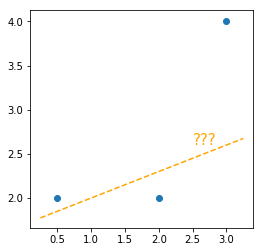

In [39]:
plt.figure(figsize=(4,4))
x = [0.5,2,3]
y = [2,  2,4]
plt.scatter(x,y)

xspace = np.linspace(0.25, 3.25)
plt.plot(xspace, xspace*0.3 + 1.7, "--", c="orange")
plt.text(2.5, 2.6, "???", fontdict={'size':15, 'color':'orange'})

The loss function is the sum square error of the predictions:
$$\hat{y}_0 = m \cdot 0.5+b$$
$$\hat{y}_1 = m \cdot 2+b$$
$$\hat{y}_2 = m \cdot 3+b$$

$$e_0 = \hat{y}_0 - 2$$
$$e_1 = \hat{y}_1 - 2$$
$$e_2 = \hat{y}_2 - 4$$

$$sse = e_0^2 + e_1^2 + e_2^2$$

In [40]:
m = 1
b = 0
yhat_0 = m*0.5+b
yhat_1 = m*2+b
yhat_2 = m*3+b
e_0 = (yhat_0-2)
e_1 = (yhat_1-2)
e_2 = (yhat_2-4)

sse = e_0**2 + e_1**2 + e_2**2
sse

3.25

(mess around with `m` and `b` to get a lower SSE)

If we instantiate `m` and `b` as `tf.Variable` objects, all intermediate and end results are TensorFlow tensors.

In [41]:
m = tf.Variable(1.0)
b = tf.Variable(0.0)
yhat_0 = m*0.5+b
yhat_1 = m*2+b
yhat_2 = m*3+b
e_0 = (yhat_0-2)
e_1 = (yhat_1-2)
e_2 = (yhat_2-4)

sse = e_0**2 + e_1**2 + e_2**2
sse

<tf.Tensor: id=3443, shape=(), dtype=float32, numpy=3.25>

Wouldn't it be handy to have the gradient of `m` and `b` evaluated at different guesses of `m` and `b`?

In [42]:
m = tf.Variable(1.0)
b = tf.Variable(0.0)

with tf.GradientTape(persistent=True) as t:
    t.watch(m)
    t.watch(b)
    
    yhat_0 = m*0.5+b
    yhat_1 = m*2+b
    yhat_2 = m*3+b
    e_0 = (yhat_0-2)
    e_1 = (yhat_1-2)
    e_2 = (yhat_2-4)

    sse = e_0**2 + e_1**2 + e_2**2

dsse_dm = t.gradient(sse, m)
dsse_db = t.gradient(sse, b)
print( "m gradient: ", dsse_dm )
print( "b gradient: ", dsse_db )
del t

m gradient:  tf.Tensor(-7.5, shape=(), dtype=float32)
b gradient:  tf.Tensor(-5.0, shape=(), dtype=float32)


Cool let's do gradient descent

In [43]:
learning_rate = 0.03

m = tf.Variable(1.0)
b = tf.Variable(0.0)

for i in range(50):
    with tf.GradientTape(persistent=True) as t:
        t.watch(m)
        t.watch(b)

        yhat_0 = m*0.5+b
        yhat_1 = m*2+b
        yhat_2 = m*3+b
        e_0 = (yhat_0-2)
        e_1 = (yhat_1-2)
        e_2 = (yhat_2-4)

        sse = e_0**2 + e_1**2 + e_2**2

    dsse_dm = t.gradient(sse, m)
    dsse_db = t.gradient(sse, b)
    print( "m gradient: ", dsse_dm )
    print( "b gradient: ", dsse_db )
    print( "SSE: ", sse.numpy() )
    print()
    del t
    
    m.assign( m - dsse_dm*learning_rate )
    b.assign( b - dsse_db*learning_rate )

m gradient:  tf.Tensor(-7.5, shape=(), dtype=float32)
b gradient:  tf.Tensor(-5.0, shape=(), dtype=float32)
SSE:  3.25

m gradient:  tf.Tensor(0.11250234, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.624999, shape=(), dtype=float32)
SSE:  1.9220312

m gradient:  tf.Tensor(0.5593126, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.3696251, shape=(), dtype=float32)
SSE:  1.8479036

m gradient:  tf.Tensor(0.56663346, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.3076663, shape=(), dtype=float32)
SSE:  1.7834538

m gradient:  tf.Tensor(0.5476885, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.2592759, shape=(), dtype=float32)
SSE:  1.7236321

m gradient:  tf.Tensor(0.5278406, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.2133422, shape=(), dtype=float32)
SSE:  1.6680908

m gradient:  tf.Tensor(0.50860906, shape=(), dtype=float32)
b gradient:  tf.Tensor(-1.1691284, shape=(), dtype=float32)
SSE:  1.6165233

m gradient:  tf.Tensor(0.4900775, shape=(), dtype=float32)
b g

In [44]:
m, b

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.8186195>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.1278102>)

Text(2.5, 2.8, ':)')

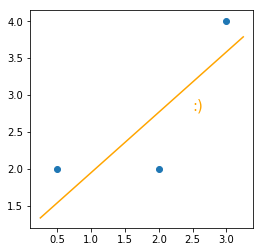

In [45]:
plt.figure(figsize=(4,4))
x = [0.5,2,3]
y = [2,2,4]
plt.scatter(x,y)

xspace = np.linspace(0.25, 3.25)
plt.plot(xspace, xspace*m.numpy() + b.numpy(), "-", c="orange")
plt.text(2.5, 2.8, ":)", fontdict={'size':15, 'color':'orange'})

We did it!

Note that

$$\hat{y}_0 = m \cdot 0.5+b$$
$$\hat{y}_1 = m \cdot 2+b$$
$$\hat{y}_2 = m \cdot 3+b$$

can be expressed more succinctly as

$$\hat{y} = \beta X$$

where $\beta$ comprises the coefficients and intercept (in this case `[m b]`) and $X$ is composed of the data $x$ augmented with a column of ones:

$$
  X = \begin{bmatrix}
    0.5 & 1 \\
    2 & 1 \\
    3 & 1
  \end{bmatrix}
$$

And then the error term is succinctly expressed as:

$$sse = \sum (\hat{y}-y)^2$$

In [46]:
x = np.array([0.5, 2, 3])
y = np.expand_dims( np.array([2, 2, 4]), 1 ) #it's convenient if y is a column vector

# augment x with an intercept column
X = np.stack( [x, np.ones_like(x)] ).T

print( X )
print( y )

[[0.5 1. ]
 [2.  1. ]
 [3.  1. ]]
[[2]
 [2]
 [4]]


In [47]:
beta = tf.Variable([[1.0], [0.0]], dtype=tf.double)

In [48]:
with tf.GradientTape(persistent=True) as t:
    t.watch(beta)
    
    error = X@beta - y
    sse = sum( error**2 )

In [49]:
t.gradient(sse, beta)

<tf.Tensor: id=14052, shape=(2, 1), dtype=float64, numpy=
array([[-7.5],
       [-5. ]])>

At this point we're ready to fit the slopes and intercept $\beta$ via gradient descent.

### Matrices for large datasets with n>3

Using this approach, we can fit a dataset of any size.


In [50]:
m, b = 0.6, 4.0

x = np.random.normal(size=(500))
y = m*x + b + np.random.normal(loc=0 ,scale=0.3, size=500)

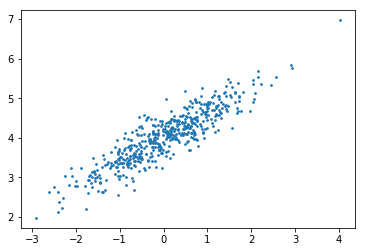

In [51]:
plt.scatter(x,y, s=3)

In [52]:
# augment x with an intercept column
X = np.stack( [x, np.ones_like(x)] ).T
y = np.expand_dims( y, 1 ) #it's convenient if y is a column vector

In [53]:
beta = tf.Variable([[1.0], [0.0]], dtype=tf.double)

with tf.GradientTape(persistent=True) as t:
    t.watch(beta)
    
    yhat = X @ beta
    sse = tf.reduce_sum( (yhat-y)**2 )
    
t.gradient(sse, beta)

<tf.Tensor: id=14102, shape=(2, 1), dtype=float64, numpy=
array([[  350.70838439],
       [-4009.94776762]])>

## Optimizer classes

We could do the whole gradient descent dance again, but instead we'll use a TensorFlow `optimizer` class, which automates gradient descent.

In [54]:
optimizer = tf.optimizers.SGD(learning_rate=0.0001)

beta = tf.Variable([[1.0], [0.0]], dtype=tf.double)

In [55]:
model = lambda: tf.reduce_sum( (X@beta - y)**2 )
for _ in range(100):
    optimizer.minimize(model, [beta])

In [56]:
beta

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[0.61075509],
       [4.01423698]])>

Behold, we've recovered the original $m$ and $b$.

## High level abstraction with Keras

Keras is a way of describing neural networks at a high level of abstraction. Keras isn't software itself, it's a _format for interacting with software_; it's an API. In Keras linear transformation between layers is a "Dense" layer. A linear transformation to a scalar is just a dense layer with an output of size (1,).

Thus, it's possible to describe a linear regression model in Keras.

In [57]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, use_bias=False)
])

model.compile(optimizer='sgd',
              loss=lambda a,b: tf.reduce_sum((a-b)**2))

hist = model.fit(X,
          y,
          epochs=10)

Epoch 1/10
500/500 [==============================] - 0s 102us/sample - loss: 168.2200
Epoch 2/10
500/500 [==============================] - 0s 56us/sample - loss: 23.6908
Epoch 3/10
500/500 [==============================] - 0s 96us/sample - loss: 5.3960
Epoch 4/10
500/500 [==============================] - 0s 50us/sample - loss: 3.1539
Epoch 5/10
500/500 [==============================] - 0s 61us/sample - loss: 2.8700
Epoch 6/10
500/500 [==============================] - 0s 83us/sample - loss: 2.8328
Epoch 7/10
500/500 [==============================] - 0s 69us/sample - loss: 2.8276
Epoch 8/10
500/500 [==============================] - 0s 100us/sample - loss: 2.8279
Epoch 9/10
500/500 [==============================] - 0s 96us/sample - loss: 2.8502
Epoch 10/10
500/500 [==============================] - 0s 87us/sample - loss: 2.8206


In [58]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.61369437],
        [4.017309  ]], dtype=float32)>]

We've used Keras in TensorFlow to do linear regression, which is like

<img src="https://external-preview.redd.it/Lws1xMKYyOqF5ZJtLOhQU2BL83kChqZJq8jRUKffXag.jpg?auto=webp&s=465b8e8f2662a9dd0e142709e1146ddbefe8bca3">

## What about classification?

Aren't neural networks all about classification? What does any of this have to do with classification?

In [59]:
np.random.seed(42)

n=100
y = np.array( [0]*n+[1]*n )
x = np.concatenate( [np.random.normal(loc=0, size=n), np.random.normal(loc=3, size=n)] )

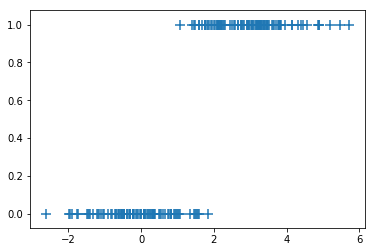

In [60]:
plt.scatter(x,y, marker="+", s=100)

Let's try a linear model.

In [61]:
m, b = 1, 0 #initial parameter guesses

In [62]:
yhat = m*x+b #our model

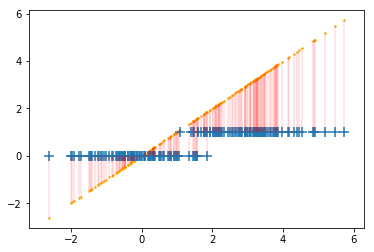

In [63]:
plt.scatter(x, yhat, color="orange", s=2)
plt.scatter(x,y,marker="+", s=100)
for x_i, y_i, yhat_i in zip(x, y, yhat):
    plt.plot([x_i,x_i],[y_i,yhat_i], c="red", lw=0.2)

Square all those red lines and add them up and we get our loss. Just at a glance, this isn't a great fit.

In [64]:
sum( (yhat-y)**2 )

581.7411788762043

What if we squish the line down to the range `[0,1]` using a sigmoid function?

In [65]:
yhat = 1/(1+np.exp(-(m*x+b))) #our model

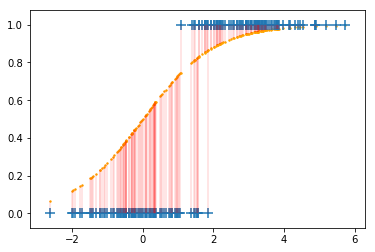

In [66]:
plt.scatter(x, yhat, color="orange", s=2)
plt.scatter(x,y,marker="+", s=100)
for x_i, y_i, yhat_i in zip(x, y, yhat):
    plt.plot([x_i,x_i],[y_i,yhat_i], c="red", lw=0.2)

Just based on the sum square error alone, this is already a huge win.

In [67]:
sum( (yhat-y)**2 )

27.38837116706314

Typically for evaluating probabilistic loss we go with cross-entropy (aka sum log likelihood):

$$loss = \sum -(y \log(\hat{y})+(1-y)\log(1−\hat{y}))$$

In [68]:
sum( -(y*np.log(yhat)+(1-y)*np.log(1-yhat)) )

80.4242968371776

Oh snap that's a differentiable loss function. We can find good model parameters with gradient descent, the **all-hammer of machine learning**.

In [69]:
X = np.stack([x,np.ones_like(x)]).T
y_col = np.expand_dims(y,axis=1)

beta = tf.Variable([[1.0], [0.0]])

In [70]:
def model(beta):
    return 1/(1+tf.exp(-(X@beta))) #our model

In [71]:
def cross_entropy(y, yhat):
    return tf.reduce_sum(-(y*tf.math.log(yhat)+(1-y)*tf.math.log(1-yhat)))

In [72]:
beta = tf.Variable([[1.0], [0.0]], dtype=tf.double)

with tf.GradientTape(persistent=True) as t:
    t.watch(beta)
    
    yhat = model(beta)
    loss = cross_entropy(y_col, yhat)
    
t.gradient(loss, beta)

<tf.Tensor: id=19823, shape=(2, 1), dtype=float64, numpy=
array([[-2.65443548],
       [41.50333482]])>

The gradient points the way to nudge our parameters $\beta$.

In [73]:
optimizer = tf.optimizers.SGD(learning_rate=0.03)

beta = tf.Variable([[1.0], [0.0]], dtype=tf.double)

for i in range(100):
    optimizer.minimize(lambda: cross_entropy(y_col, model(beta)), [beta])

In [74]:
m, b = beta.numpy().ravel()
m,b

(4.418187527716732, -6.430974483099049)

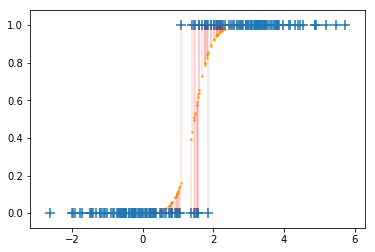

In [75]:
yhat = 1/(1+np.exp(-(m*x+b))) #our model
plt.scatter(x, yhat, color="orange", s=2)
plt.scatter(x,y,marker="+", s=100)
for x_i, y_i, yhat_i in zip(x, y, yhat):
    plt.plot([x_i,x_i],[y_i,yhat_i], c="red", lw=0.2)

In [76]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, use_bias=False, activation="sigmoid")
])

model.compile(optimizer='sgd',
              loss=cross_entropy)

hist = model.fit(X,
                y,
                epochs=1000,
                batch_size=200)

Epoch 1/1000
200/200 [==============================] - 0s 155us/sample - loss: 167.3427
Epoch 2/1000
200/200 [==============================] - 0s 9us/sample - loss: 118.7020
Epoch 3/1000
200/200 [==============================] - 0s 14us/sample - loss: 92.1957
Epoch 4/1000
200/200 [==============================] - 0s 15us/sample - loss: 78.1108
Epoch 5/1000
200/200 [==============================] - 0s 23us/sample - loss: 69.9633
Epoch 6/1000
200/200 [==============================] - 0s 35us/sample - loss: 64.7921
Epoch 7/1000
200/200 [==============================] - 0s 13us/sample - loss: 61.2519
Epoch 8/1000
200/200 [==============================] - 0s 17us/sample - loss: 58.6793
Epoch 9/1000
200/200 [==============================] - 0s 15us/sample - loss: 56.7184
Epoch 10/1000
200/200 [==============================] - 0s 18us/sample - loss: 55.1647
Epoch 11/1000
200/200 [==============================] - 0s 64us/sample - loss: 53.8933
Epoch 12/1000
200/200 [================

Epoch 95/1000
200/200 [==============================] - 0s 15us/sample - loss: 32.6958
Epoch 96/1000
200/200 [==============================] - 0s 36us/sample - loss: 32.5973
Epoch 97/1000
200/200 [==============================] - 0s 46us/sample - loss: 32.5001
Epoch 98/1000
200/200 [==============================] - 0s 16us/sample - loss: 32.4040
Epoch 99/1000
200/200 [==============================] - 0s 39us/sample - loss: 32.3092
Epoch 100/1000
200/200 [==============================] - 0s 17us/sample - loss: 32.2155
Epoch 101/1000
200/200 [==============================] - 0s 27us/sample - loss: 32.1229
Epoch 102/1000
200/200 [==============================] - 0s 13us/sample - loss: 32.0315
Epoch 103/1000
200/200 [==============================] - 0s 35us/sample - loss: 31.9412
Epoch 104/1000
200/200 [==============================] - 0s 11us/sample - loss: 31.8519
Epoch 105/1000
200/200 [==============================] - 0s 14us/sample - loss: 31.7637
Epoch 106/1000
200/200 [==

200/200 [==============================] - 0s 37us/sample - loss: 26.8959
Epoch 188/1000
200/200 [==============================] - 0s 34us/sample - loss: 26.8555
Epoch 189/1000
200/200 [==============================] - 0s 23us/sample - loss: 26.8155
Epoch 190/1000
200/200 [==============================] - 0s 29us/sample - loss: 26.7758
Epoch 191/1000
200/200 [==============================] - 0s 17us/sample - loss: 26.7364
Epoch 192/1000
200/200 [==============================] - 0s 17us/sample - loss: 26.6973
Epoch 193/1000
200/200 [==============================] - 0s 27us/sample - loss: 26.6584
Epoch 194/1000
200/200 [==============================] - 0s 43us/sample - loss: 26.6199
Epoch 195/1000
200/200 [==============================] - 0s 22us/sample - loss: 26.5816
Epoch 196/1000
200/200 [==============================] - 0s 52us/sample - loss: 26.5436
Epoch 197/1000
200/200 [==============================] - 0s 20us/sample - loss: 26.5059
Epoch 198/1000
200/200 [============

Epoch 280/1000
200/200 [==============================] - 0s 36us/sample - loss: 24.1054
Epoch 281/1000
200/200 [==============================] - 0s 27us/sample - loss: 24.0831
Epoch 282/1000
200/200 [==============================] - 0s 111us/sample - loss: 24.0609
Epoch 283/1000
200/200 [==============================] - 0s 45us/sample - loss: 24.0389
Epoch 284/1000
200/200 [==============================] - 0s 15us/sample - loss: 24.0169
Epoch 285/1000
200/200 [==============================] - 0s 92us/sample - loss: 23.9951
Epoch 286/1000
200/200 [==============================] - 0s 14us/sample - loss: 23.9734
Epoch 287/1000
200/200 [==============================] - 0s 33us/sample - loss: 23.9519
Epoch 288/1000
200/200 [==============================] - 0s 18us/sample - loss: 23.9304
Epoch 289/1000
200/200 [==============================] - 0s 15us/sample - loss: 23.9090
Epoch 290/1000
200/200 [==============================] - 0s 13us/sample - loss: 23.8878
Epoch 291/1000
200/2

Epoch 373/1000
200/200 [==============================] - 0s 47us/sample - loss: 22.4406
Epoch 374/1000
200/200 [==============================] - 0s 26us/sample - loss: 22.4262
Epoch 375/1000
200/200 [==============================] - 0s 39us/sample - loss: 22.4120
Epoch 376/1000
200/200 [==============================] - 0s 24us/sample - loss: 22.3977
Epoch 377/1000
200/200 [==============================] - 0s 8us/sample - loss: 22.3836
Epoch 378/1000
200/200 [==============================] - 0s 16us/sample - loss: 22.3695
Epoch 379/1000
200/200 [==============================] - 0s 14us/sample - loss: 22.3554
Epoch 380/1000
200/200 [==============================] - 0s 44us/sample - loss: 22.3414
Epoch 381/1000
200/200 [==============================] - 0s 46us/sample - loss: 22.3275
Epoch 382/1000
200/200 [==============================] - 0s 20us/sample - loss: 22.3136
Epoch 383/1000
200/200 [==============================] - 0s 101us/sample - loss: 22.2998
Epoch 384/1000
200/20

200/200 [==============================] - 0s 48us/sample - loss: 21.3300
Epoch 466/1000
200/200 [==============================] - 0s 25us/sample - loss: 21.3199
Epoch 467/1000
200/200 [==============================] - 0s 14us/sample - loss: 21.3098
Epoch 468/1000
200/200 [==============================] - 0s 14us/sample - loss: 21.2997
Epoch 469/1000
200/200 [==============================] - 0s 26us/sample - loss: 21.2897
Epoch 470/1000
200/200 [==============================] - 0s 21us/sample - loss: 21.2797
Epoch 471/1000
200/200 [==============================] - 0s 50us/sample - loss: 21.2697
Epoch 472/1000
200/200 [==============================] - 0s 23us/sample - loss: 21.2598
Epoch 473/1000
200/200 [==============================] - 0s 30us/sample - loss: 21.2499
Epoch 474/1000
200/200 [==============================] - 0s 35us/sample - loss: 21.2401
Epoch 475/1000
200/200 [==============================] - 0s 29us/sample - loss: 21.2302
Epoch 476/1000
200/200 [============

200/200 [==============================] - 0s 26us/sample - loss: 20.5226
Epoch 558/1000
200/200 [==============================] - 0s 27us/sample - loss: 20.5150
Epoch 559/1000
200/200 [==============================] - 0s 31us/sample - loss: 20.5074
Epoch 560/1000
200/200 [==============================] - 0s 15us/sample - loss: 20.4999
Epoch 561/1000
200/200 [==============================] - 0s 29us/sample - loss: 20.4924
Epoch 562/1000
200/200 [==============================] - 0s 31us/sample - loss: 20.4849
Epoch 563/1000
200/200 [==============================] - 0s 31us/sample - loss: 20.4774
Epoch 564/1000
200/200 [==============================] - 0s 74us/sample - loss: 20.4699
Epoch 565/1000
200/200 [==============================] - 0s 69us/sample - loss: 20.4625
Epoch 566/1000
200/200 [==============================] - 0s 67us/sample - loss: 20.4551
Epoch 567/1000
200/200 [==============================] - 0s 51us/sample - loss: 20.4477
Epoch 568/1000
200/200 [============

Epoch 650/1000
200/200 [==============================] - 0s 9us/sample - loss: 19.8999
Epoch 651/1000
200/200 [==============================] - 0s 34us/sample - loss: 19.8940
Epoch 652/1000
200/200 [==============================] - 0s 8us/sample - loss: 19.8881
Epoch 653/1000
200/200 [==============================] - 0s 11us/sample - loss: 19.8823
Epoch 654/1000
200/200 [==============================] - 0s 12us/sample - loss: 19.8764
Epoch 655/1000
200/200 [==============================] - 0s 26us/sample - loss: 19.8706
Epoch 656/1000
200/200 [==============================] - 0s 15us/sample - loss: 19.8647
Epoch 657/1000
200/200 [==============================] - 0s 13us/sample - loss: 19.8589
Epoch 658/1000
200/200 [==============================] - 0s 153us/sample - loss: 19.8531
Epoch 659/1000
200/200 [==============================] - 0s 15us/sample - loss: 19.8474
Epoch 660/1000
200/200 [==============================] - 0s 81us/sample - loss: 19.8416
Epoch 661/1000
200/200

Epoch 742/1000
200/200 [==============================] - 0s 18us/sample - loss: 19.4129
Epoch 743/1000
200/200 [==============================] - 0s 29us/sample - loss: 19.4082
Epoch 744/1000
200/200 [==============================] - 0s 12us/sample - loss: 19.4034
Epoch 745/1000
200/200 [==============================] - 0s 20us/sample - loss: 19.3987
Epoch 746/1000
200/200 [==============================] - 0s 13us/sample - loss: 19.3940
Epoch 747/1000
200/200 [==============================] - 0s 40us/sample - loss: 19.3893
Epoch 748/1000
200/200 [==============================] - 0s 57us/sample - loss: 19.3846
Epoch 749/1000
200/200 [==============================] - 0s 9us/sample - loss: 19.3799
Epoch 750/1000
200/200 [==============================] - 0s 22us/sample - loss: 19.3753
Epoch 751/1000
200/200 [==============================] - 0s 14us/sample - loss: 19.3706
Epoch 752/1000
200/200 [==============================] - 0s 18us/sample - loss: 19.3660
Epoch 753/1000
200/200

Epoch 835/1000
200/200 [==============================] - 0s 18us/sample - loss: 19.0129
Epoch 836/1000
200/200 [==============================] - 0s 35us/sample - loss: 19.0090
Epoch 837/1000
200/200 [==============================] - 0s 15us/sample - loss: 19.0051
Epoch 838/1000
200/200 [==============================] - 0s 32us/sample - loss: 19.0012
Epoch 839/1000
200/200 [==============================] - 0s 13us/sample - loss: 18.9974
Epoch 840/1000
200/200 [==============================] - 0s 19us/sample - loss: 18.9935
Epoch 841/1000
200/200 [==============================] - 0s 27us/sample - loss: 18.9897
Epoch 842/1000
200/200 [==============================] - 0s 31us/sample - loss: 18.9858
Epoch 843/1000
200/200 [==============================] - 0s 20us/sample - loss: 18.9820
Epoch 844/1000
200/200 [==============================] - 0s 39us/sample - loss: 18.9781
Epoch 845/1000
200/200 [==============================] - 0s 15us/sample - loss: 18.9743
Epoch 846/1000
200/20

Epoch 928/1000
200/200 [==============================] - 0s 20us/sample - loss: 18.6813
Epoch 929/1000
200/200 [==============================] - 0s 54us/sample - loss: 18.6780
Epoch 930/1000
200/200 [==============================] - 0s 22us/sample - loss: 18.6748
Epoch 931/1000
200/200 [==============================] - 0s 15us/sample - loss: 18.6715
Epoch 932/1000
200/200 [==============================] - 0s 15us/sample - loss: 18.6683
Epoch 933/1000
200/200 [==============================] - 0s 16us/sample - loss: 18.6650
Epoch 934/1000
200/200 [==============================] - 0s 13us/sample - loss: 18.6618
Epoch 935/1000
200/200 [==============================] - 0s 10us/sample - loss: 18.6586
Epoch 936/1000
200/200 [==============================] - 0s 64us/sample - loss: 18.6554
Epoch 937/1000
200/200 [==============================] - 0s 14us/sample - loss: 18.6521
Epoch 938/1000
200/200 [==============================] - 0s 111us/sample - loss: 18.6489
Epoch 939/1000
200/2

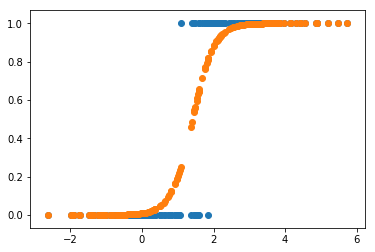

In [77]:
plt.scatter(X[:,0],y)
plt.scatter(X[:,0],model.apply(X))

In [78]:
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 3.3597586],
        [-4.730612 ]], dtype=float32)>]

Behold, a neural net with no hidden layer is logistic regression. Side note: Keras is taking a lot longer and getting a worse fit than manual gradient descent. NN training is very fickle.